In [1]:
import warnings
warnings.filterwarnings('ignore')
from numpy import set_printoptions
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
pd.options.display.max_columns=None
import seaborn as sns 
from pandas import read_csv
import io
import base64
import json
from openpyxl import Workbook
from openpyxl.drawing.image import Image as XLImage

import os
import os.path
from unidecode import unidecode

from urllib.error import HTTPError

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaIoBaseDownload

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from mlens.ensemble import SuperLearner

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_log_error, median_absolute_error
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

[MLENS] backend: threading


### CARGUE DE DATOS Y CONEXIÓN A DRIVE

In [2]:
SCOPES = ['https://www.googleapis.com/auth/drive.readonly']

creds = None
if os.path.exists('token.json'):
    creds = Credentials.from_authorized_user_file('token.json', SCOPES)
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file('C:/Users/Intevo/Desktop/UNIVERSIDAD DISTRITAL PROYECTO FOLDER/credentials.json', SCOPES) # Reemplazar con la ruta correcta
        creds = flow.run_local_server(port=0)
    with open('C:/Users/Intevo/Desktop/UNIVERSIDAD DISTRITAL PROYECTO FOLDER/token.json', 'w') as token:
        token.write(creds.to_json())
        
# Crear una instancia de la API de Drive
drive_service = build('drive', 'v3', credentials=creds)

# ID de la carpeta de Google Drive
folder_id = '1hQeetmO4XIObUefS_nzePqKqq3VksUEC'

# Ruta de destino para guardar los archivos descargados
save_path = 'C:/Users/Intevo/Desktop/UNIVERSIDAD DISTRITAL PROYECTO FOLDER/UNIVERSIDAD-DISTRITAL-PROYECTO/MODULO_ANALITICA_PRACTICO/DATOS'  # Reemplazar con la ruta deseada

# Función para descargar archivos de la carpeta de Drive
def download_folder(folder_id, save_path):
    results = drive_service.files().list(
        q=f"'{folder_id}' in parents and trashed=false",
        fields='files(id, name)').execute()
    items = results.get('files', [])
    for item in items:
        file_id = item['id']
        file_name = item['name']
        request = drive_service.files().get_media(fileId=file_id)
        fh = io.FileIO(os.path.join(save_path, file_name), 'wb')
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while done is False:
            status, done = downloader.next_chunk()
            print(f"Descargando {file_name}: {int(status.progress() * 100)}%")
    print("Descarga completa")

# Descargar archivos de la carpeta
download_folder(folder_id, save_path)

# Listar archivos descargados
files = os.listdir(save_path)
print("Archivos descargados:")
for file in files:
    print(file)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=899973764197-biu188dkvsgi2al0fh29udm7keak0lh0.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A53852%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.readonly&state=fdujSJa8TXUyu6scOai5Ke6ma1DoUU&access_type=offline
Descargando Limpieza de datos 1 UD.ipynb: 100%
Descargando industrial9.csv: 100%
Descargando industrial4.csv: 100%
Descargando industrial3.csv: 100%
Descargando industrial10.csv: 100%
Descargando industrial6.csv: 100%
Descargando industrial5.csv: 100%
Descargando industrial2.csv: 100%
Descargando industrial8.csv: 100%
Descargando industrial7.csv: 100%
Descargando industrial1.csv: 100%
Descargando sistemas10.csv: 100%
Descargando sistemas6.csv: 100%
Descargando sistemas2.csv: 100%
Descargando sistemas7.csv: 100%
Descargando sistemas4.csv: 100%
Descargando sistemas9.csv: 100%
Descargando sistemas5.csv: 100%
Descargando sistemas3.c

In [3]:
variables_por_carrera = { 
    'industrial': {
        '1': ['PG_ICFES', 'CON_MAT_ICFES', 'FISICA_ICFES','QUIMICA_ICFES','IDIOMA_ICFES','LOCALIDAD','PROMEDIO_UNO'],
        '2': ['LOCALIDAD_COLEGIO', 'PG_ICFES', 'CON_MAT_ICFES', 'FISICA_ICFES', 'BIOLOGIA_ICFES', 'IDIOMA_ICFES', 'LOCALIDAD', 'PROMEDIO_UNO', 'CAR_UNO', 'NCC_UNO', 'NAA_UNO', 'NOTA_DIFERENCIAL', 'NOTA_DIBUJO', 'NOTA_QUIMICA', 'NOTA_CFJC', 'NOTA_TEXTOS', 'NOTA_SEMINARIO', 'NOTA_EE_UNO','PROMEDIO_DOS'],
        '3': ['PROMEDIO_UNO', 'NAA_UNO', 'NOTA_DIFERENCIAL', 'NOTA_DIBUJO', 'NOTA_TEXTOS', 'NOTA_EE_UNO', 'PROMEDIO_DOS', 'NCC_DOS', 'NCA_DOS', 'NAA_DOS', 'NOTA_ALGEBRA', 'NOTA_INTEGRAL', 'NOTA_MATERIALES', 'NOTA_PBASICA', 'NOTA_EE_DOS', 'PROMEDIO_TRES'],
        '4': ['PROMEDIO_UNO', 'NOTA_EE_UNO', 'PROMEDIO_DOS', 'NOTA_ALGEBRA', 'NOTA_INTEGRAL', 'NOTA_MATERIALES', 'NOTA_EE_DOS', 'NAA_TRES', 'NOTA_MULTIVARIADO', 'NOTA_ESTADISTICA_UNO', 'NOTA_TERMODINAMICA', 'NOTA_TGS', 'NOTA_EE_TRES','PROMEDIO_CUATRO'],
        '5': ['PROMEDIO_UNO', 'PROMEDIO_DOS', 'NOTA_ALGEBRA', 'NOTA_INTEGRAL', 'NOTA_MATERIALES', 'NOTA_EE_DOS','PROMEDIO_TRES', 'NAA_TRES', 'NOTA_MULTIVARIADO', 'NOTA_TERMODINAMICA', 'NOTA_ECUACIONES', 'NOTA_ESTADISTICA_DOS', 'NOTA_FISICA_DOS', 'NOTA_MECANICA', 'NOTA_PROCESOSQ', 'PROMEDIO_CINCO'],
        '6': ['PROMEDIO_UNO', 'PROMEDIO_DOS', 'NOTA_MATERIALES', 'NOTA_EE_DOS', 'PROMEDIO_TRES', 'NOTA_MULTIVARIADO', 'NOTA_FISICA_DOS', 'NOTA_EE_CUATRO', 'PROMEDIO_CINCO', 'NOTA_PROCESOSM', 'NOTA_ADMINISTRACION', 'NOTA_LENGUA_UNO', 'NOTA_EI_UNO', 'NOTA_EI_DOS', 'PROMEDIO_SEIS'],
        '7': ['PROMEDIO_UNO', 'PROMEDIO_DOS', 'NOTA_EE_DOS', 'PROMEDIO_TRES', 'NOTA_MULTIVARIADO', 'NOTA_FISICA_DOS', 'PROMEDIO_CINCO', 'NOTA_PROCESOSM', 'NOTA_LENGUA_UNO', 'NOTA_EI_DOS', 'PROMEDIO_SEIS', 'NCA_SEIS', 'NOTA_PLINEAL', 'NOTA_DISENO', 'NOTA_EI_TRES','PROMEDIO_SIETE'],
        '8': ['PROMEDIO_DOS', 'NOTA_EE_CUATRO', 'PROMEDIO_CINCO', 'NOTA_LENGUA_UNO','PROMEDIO_SEIS', 'NOTA_IECONOMICA', 'PROMEDIO_SIETE', 'NAA_SIETE', 'NOTA_GRAFOS', 'NOTA_CALIDAD_UNO', 'NOTA_ERGONOMIA', 'NOTA_EI_CINCO', 'PROMEDIO_OCHO'],
        '9': ['PROMEDIO_DOS', 'NOTA_EE_CUATRO', 'PROMEDIO_CINCO', 'PROMEDIO_SEIS', 'NOTA_IECONOMICA', 'PROMEDIO_SIETE', 'NAA_SIETE', 'NOTA_GRAFOS', 'NOTA_CALIDAD_UNO', 'NOTA_ERGONOMIA', 'NOTA_EI_CINCO', 'PROMEDIO_OCHO', 'NCC_OCHO', 'NOTA_LOG_UNO', 'NOTA_GOPERACIONES','NOTA_CALIDAD_DOS', 'NOTA_LENGUA_DOS', 'NOTA_CONTEXTO', 'PROMEDIO_NUEVE'],
        '10': ['PROMEDIO_SEIS', 'PROMEDIO_SIETE', 'PROMEDIO_OCHO', 'NOTA_CALIDAD_DOS', 'PROMEDIO_NUEVE', 'NAA_NUEVE', 'NOTA_GRADO_UNO', 'NOTA_LOG_DOS', 'NOTA_FINANZAS', 'NOTA_HISTORIA', 'PROMEDIO_DIEZ']
    },
    'sistemas': {
        '1': ['CON_MAT_ICFES','IDIOMA_ICFES','LOCALIDAD_COLEGIO','BIOLOGIA_ICFES','QUIMICA_ICFES','PG_ICFES','LITERATURA_ICFES','PROMEDIO_UNO'],
        '2': ['PROMEDIO_UNO','NOTA_DIFERENCIAL','NOTA_CATEDRA_DEM','NOTA_PROG_BASICA','NAA_UNO','CAR_UNO','NOTA_TEXTOS','NOTA_LOGICA','NOTA_SEMINARIO','VECES_LOGICA','NAC_UNO','NCC_UNO','NCA_UNO','IDIOMA_ICFES','VECES_CATEDRA_DEM','NOTA_EE_UNO','PG_ICFES','NAP_UNO','VECES_DIFERENCIAL','CON_MAT_ICFES','NOTA_CATEDRA_CON','VECES_EE_UNO','PROMEDIO_DOS'],
        '3': ['PROMEDIO_UNO','PROMEDIO_DOS','NOTA_TGS','NOTA_PROG_AVANZADA','NOTA_FISICA_DOS','NOTA_MULTIVARIADO','NOTA_SEGUNDA_LENGUA_DOS','VECES_FISICA_DOS','NOTA_EE_DOS','VECES_PROG_AVANZADA','NAA_DOS','VECES_TGS','NCA_DOS','VECES_MULTIVARIADO','NOTA_ECUACIONES','NOTA_DIFERENCIAL','NAC_DOS','PROMEDIO_TRES'],
        '4': ['PROMEDIO_UNO','PROMEDIO_DOS','NOTA_METODOS_NUM','NOTA_A_SISTEMAS','NOTA_MOD_PROG_UNO','NOTA_MAT_DIS','NOTA_HOMBRE','NOTA_GT_DOS','VECES_A_SISTEMAS','VECES_HOMBRE','NCC_TRES','NAA_DOS','NAA_TRES','NOTA_FUND_BASES','NAC_TRES','PROMEDIO_CUATRO'],
        '5': ['PROMEDIO_UNO','PROMEDIO_DOS','PROMEDIO_TRES','NOTA_PROB','NOTA_CIENCIAS_COMP_UNO','NOTA_MOD_PROG_DOS','NOTA_ARQ_COMP','NOTA_INV_OP_UNO','NOTA_FISICA_TRES','VECES_INV_OP_UNO','VECES_PROB','NOTA_METODOS_NUM','NOTA_MOD_PROG_UNO','VECES_MOD_PROG_DOS','VECES_FISICA_TRES','PROMEDIO_CINCO'],
        '6': ['PROMEDIO_UNO','PROMEDIO_DOS','PROMEDIO_TRES','NOTA_HISTORIA_COL','NOTA_ESTADISTICA','NOTA_CIBERNETICA_UNO','NOTA_INV_OP_DOS','NOTA_REDES_COM_UNO','NOTA_GI_UNO','VECES_HISTORIA_COL','VECES_CIBERNETICA_UNO','NOTA_CIENCIAS_COMP_DOS','VECES_REDES_COM_UNO','VECES_GI_UNO','VECES_ESTADISTICA','NOTA_MOD_PROG_DOS','VECES_CIENCIAS_COMP_DOS','VECES_INV_OP_DOS','CAR_CINCO','NOTA_METODOS_NUM','VECES_FISICA_TRES','PROMEDIO_SEIS'],
        '7': ['PROMEDIO_UNO','PROMEDIO_DOS','PROMEDIO_TRES','PROMEDIO_CINCO','NOTA_F_ING_SOF','NOTA_GT_TRES','NOTA_ECONOMIA','NOTA_EI_DOS','NOTA_REDES_COM_DOS','VECES_ECONOMIA','NOTA_CIBERNETICA_UDOS','NOTA_INV_OP_TRES','NOTA_INV_OP_DOS','NOTA_HISTORIA_COL','VECES_F_ING_SOF','VECES_REDES_COM_DOS','NOTA_METODOS_NUM','VECES_EI_DOS','VECES_CIBERNETICA_DOS','NOTA_ESTADISTICA','NCP_SEIS','NOTA_MOD_PROG_DOS','NOTA_GI_DOS','PROMEDIO_SIETE'],
        '8': ['PROMEDIO_UNO','PROMEDIO_DOS','PROMEDIO_TRES','PROMEDIO_CINCO','PROMEDIO_SEIS','NOTA_DIS_ARQ_SOFT','NOTA_EI_OP_AI','NOTA_ING_ECONOMICA','NOTA_REDES_COM_TRES','NOTA_CIBERNETICA_TRES','VECES_EI_OP_AI','VECES_DIS_ARQ_SOFT','VECES_ING_ECONOMICA','VECES_EI_OP_BI','VECES_CIBERNETICA_TRES','NOTA_INV_OP_DOS','PROMEDIO_OCHO'],
        '9': ['PROMEDIO_TRES','PROMEDIO_CINCO','PROMEDIO_SEIS','PROMEDIO_SIETE','NOTA_EI_OP_AII','NOTA_GES_CAL_VAL_SOFT','NOTA_EI_OP_CI','NOTA_SIS_OP','VECES_EI_OP_AII','VECES_SIS_OP','NOTA_ING_ECONOMICA','VECES_EI_OP_CI','NAC_OCHO','VECES_GES_CAL_VAL_SOFT','PROMEDIO_NUEVE'],
        '10': ['PROMEDIO_TRES','PROMEDIO_CINCO','PROMEDIO_SEIS','PROMEDIO_SIETE','NOTA_FOGEP','NOTA_EI_OP_DI','NOTA_EI_OP_CII','NOTA_EI_OP_CI','NOTA_EI_OP_AIII','NOTA_ING_ECONOMICA','VECES_FOGEP','NOTA_GRADO_UNO','NOTA_GRADO_DOS','VECES_EI_OP_DI','NOTA_EI_OP_BIII','NCP_NUEVE','NOTA_GES_CAL_VAL_SOFT','PROMEDIO_DIEZ']
    },
    'catastral': {
        '1': ['CON_MAT_ICFES','IDIOMA_ICFES','BIOLOGIA_ICFES','GENERO','FILOSOFIA_ICFES','LOCALIDAD','LITERATURA_ICFES','QUIMICA_ICFES','PG_ICFES','PROMEDIO_UNO'],
        '2': ['PROMEDIO_UNO','NOTA_ALGEBRA','NOTA_DITO','NOTA_TEXTOS','NOTA_CD&C','NCA_UNO','NAA_UNO','BIOLOGIA_ICFES','NOTA_HIST','QUIMICA_ICFES','NOTA_SEM','FILOSOFIA_ICFES','IDIOMA_ICFES','LITERATURA_ICFES','NOTA_DIF','CON_MAT_ICFES','NAP_UNO','VECES_HIST','VECES_ALGEBRA','NCP_UNO','GENERO','PROMEDIO_DOS'],
        '3': ['PROMEDIO_UNO','PROMEDIO_DOS','EPA_DOS','NOTA_TOP','NOTA_PROGB','NOTA_FIS_UNO','NOTA_HIST','LITERATURA_ICFES','NOTA_INT','VECES_TOP','NCA_UNO','IDIOMA_ICFES','NAP_UNO','VECES_HIST','NOTA_EYB','NOTA_DIF','PROMEDIO_TRES'],
        '4': ['PROMEDIO_UNO','PROMEDIO_DOS','PROMEDIO_TRES','NOTA_DIF','NOTA_SUELOS','NOTA_POO','NOTA_FIS_DOS','NOTA_TOP','NOTA_EYB','IDIOMA_ICFES','NOTA_HIST','NOTA_ECUA','NOTA_PROGB','LITERATURA_ICFES','NCA_TRES','NOTA_FOTO','NOTA_CFJC','VECES_SUELOS','PROMEDIO_CUATRO'],
        '5': ['PROMEDIO_UNO','PROMEDIO_DOS','PROMEDIO_TRES','PROMEDIO_CUATRO','NOTA_GEOGEO','NOTA_TOP','NCA_CUATRO','NOTA_SUELOS','NOTA_POO','NOTA_PRII','NOTA_FOTO','EPA_CUATRO','LITERATURA_ICFES','NOTA_PROGB','NOTA_PROB','NOTA_ECUA','NOTA_CFJC','PROMEDIO_CINCO'],
        '6': ['PROMEDIO_UNO','PROMEDIO_DOS','PROMEDIO_TRES','PROMEDIO_CUATRO','PROMEDIO_CINCO','NOTA_SUELOS','NOTAS_SISC','NOTA_TOP','NOTA_GEOGEO','NOTA_POO','VECES_BD','NOTA_ME','NOTA_ECUA','CAR_CINCO','NOTA_PROGB','NOTA_FOTO','NOTA_CARTO','LITERATURA_ICFES','VECES_CARTO','NOTA_CFJC','PROMEDIO_SEIS'],
        '7': ['PROMEDIO_UNO','PROMEDIO_DOS','PROMEDIO_CUATRO','PROMEDIO_CINCO','PROMEDIO_SEIS','NOTA_GEO_FIS','NOTA_L_DOS','NOTA_ECUA','CAR_CINCO','NOTA_CARTO','NOTA_LEGIC','NOTA_GEOGEO','NOTA_POO','NOTA_CFJC','NOTA_INGECO','VECES_L_DOS','NOTA_SUELOS','NOTA_FOTO','PROMEDIO_SIETE'],
        '8': ['PROMEDIO_DOS','PROMEDIO_CINCO','PROMEDIO_SEIS','PROMEDIO_SIETE','NOTA_L_DOS','NOTA_ECONOMET','NOTA_AVAP','CAR_CINCO','NOTA_POO','NOTA_ECUA','NOTA_FOTO','NOTA_GEOGEO','NOTA_EI_UNO','PROMEDIO_OCHO'],
        '9': ['PROMEDIO_CINCO','PROMEDIO_SEIS','PROMEDIO_SIETE','PROMEDIO_OCHO','NOTA_FOTO','NOTA_POO','NOTA_L_DOS','NOTA_FOTOD','NOTA_AVAM','NOTA_AVAP','NOTA_EI_CUATRO','NOTA_L_TRES','NOTA_EI_UNO','NOTA_ECONOMET','NOTA_FGEP','NOTA_ECUA','NOTA_GEOGEO','PROMEDIO_NUEVE'],
        '10': ['PROMEDIO_CINCO','PROMEDIO_SEIS','PROMEDIO_SIETE','PROMEDIO_NUEVE','NOTA_TG_UNO','NOTA_L_DOS','NOTA_AVAP','NOTA_EI_CINCO','NOTA_ECONOMET','NOTA_AVAM','NOTA_FOTO','NOTA_FGEP','NOTA_EI_SEIS','NOTA_EE_DOS','NOTA_ECUA','PROMEDIO_DIEZ']
    },
    'electrica':{
        '1': ['IDIOMA_ICFES','PG_ICFES','FISICA_ICFES','ANO_INGRESO','APT_VERB_ICFES','QUIMICA_ICFES','FILOSOFIA_ICFES','GENERO','BIOLOGIA_ICFES','PROMEDIO_UNO'],
        '2': ['PROMEDIO_UNO','NOTA_POO','NOTA_INT','NOTA_FIS_DOS','NOTA_EYB','NOTA_DEM','NOTA_CIR_UNO','NOTA_HCI','VECES_INT','VECES_FIS_DOS','PG_ICFES','PROMEDIO_DOS'],
        '3': ['PROMEDIO_DOS','NOTA_ECUA','NOTA_TERMO','NOTA_CIR_DOS','NOTA_FIS_DOS','NOTA_EL_UNO','VECES_ECUA','NOTA_FIS_TRES','NOTA_MULTI','NCP_DOS','NCA_DOS','VECES_TERMO','PROMEDIO_TRES'],
        '4': ['PROMEDIO_DOS','NOTA_EL_DOS','NOTA_MPI','NOTA_ME','NOTA_PYE','NOTA_ELD','VECES_ME','VECES_EL_DOS','NOTA_GEE','NOTA_CIR_TRES','VECES_PYE','PROMEDIO_CUATRO'],
        '5': ['PROMEDIO_CUATRO','NOTA_ASD','NOTA_CEM','NOTA_IO_UNO','NOTA_INSE','NOTA_IYM','NOTA_EE_UNO','NOTA_GENH','VECES_CEM','NOTA_EL_DOS','VECES_IYM','VECES_INSE','PROMEDIO_CINCO'],
        '6': ['PROMEDIO_CUATRO','NOTA_INGECO','NOTA_DDP','NOTA_CTRL','NOTA_CONEM','NOTA_TDE','VECES_INGECO','VECES_IO_DOS','VECES_DDP','NAC_CINCO','NOTAS_RDC','PROMEDIO_SEIS'],
        '7': ['VECES_ECO','NOTA_L_UNO','NOTA_ASP','NOTA_ELECPOT','NOTA_ECO','NOTA_MAQEL','VECES_ASP','NAC_CINCO','NOTA_AUTO','PROMEDIO_SIETE'],
        '8': ['PROMEDIO_SIETE','NOTA_FGEP','NOTA_HIST','NOTA_CCON','NOTA_L_DOS','NOTA_AIELEC','NOTA_SUBEL','VECES_SUBEL','VECES_FGEP','VECES_L_DOS','VECES_HIST','NOTA_L_UNO','PROMEDIO_OCHO'],
        '9': ['PROMEDIO_SIETE','NOTA_L_TRES','NOTA_HSE','NOTA_ADMIN','NOTA_TGUNO','VECES_HSE','NOTA_EI_TRES','NOTA_EE_DOS','NOTA_PROTELEC','NCC_OCHO','VECES_L_TRES','VECES_PROTELEC','CAR_OCHO','VECES_ADMIN','PROMEDIO_NUEVE'],
        '10': ['PROMEDIO_NUEVE','NOTA_EI_CINCO','NOTA_TGDOS','NOTA_EI_SEIS','NOTA_EI_TRES','NOTA_EE_TRES','NOTA_EE_DOS','NCC_NUEVE','VECES_EI_CINCO','NOTA_HSE','PROMEDIO_DIEZ']
    },
    'electronica':{
        '1': ['CON_MAT_ICFES','QUIMICA_ICFES','PG_ICFES','FISICA_ICFES','IDIOMA_ICFES','BIOLOGIA_ICFES','GENERO','LOCALIDAD','LITERATURA_ICFES','PROMEDIO_UNO'],
        '2': ['PROMEDIO_UNO','NOTA_DIF','CON_MAT_ICFES','EPA_UNO','FISICA_ICFES','PG_ICFES','NOTA_PROGB','NOTA_FIS_UNO','BIOLOGIA_ICFES','IDIOMA_ICFES','LITERATURA_ICFES','NCP_UNO','NOTA_TEXTOS','NOTA_CFJC','NAP_UNO','PROMEDIO_DOS'],
        '3': ['PROMEDIO_UNO','PROMEDIO_DOS','PG_ICFES','BIOLOGIA_ICFES','NAA_DOS','FISICA_ICFES','NOTA_INT','VECES_INT','NCA_DOS','NOTA_FIS_DOS','CON_MAT_ICFES','CAR_DOS','PROMEDIO_TRES'],
        '4': ['PROMEDIO_UNO','PROMEDIO_DOS','PROMEDIO_TRES','NOTA_INT','NCA_DOS','NCA_TRES','NOTA_FIS_DOS','PG_ICFES','NOTA_FIS_TRES','NOTA_EL_UNO','VECES_FIS_TRES','NOTA_DEM','PROMEDIO_CUATRO'],
        '5': ['PROMEDIO_TRES','PROMEDIO_CUATRO','NOTA_FIS_DOS','NOTA_EL_DOS','NOTA_CAMPOS','NOTA_FCD','VECES_FCD','NOTA_PROGAPL','NOTA_VARCOM','NCA_TRES','NOTA_INT','NCP_CUATRO','PROMEDIO_CINCO'],
        '6': ['PROMEDIO_TRES','PROMEDIO_CINCO','NOTA_EE_DOS','NCC_CINCO','NOTA_ADMICRO','NOTA_FCD','NAP_CINCO','NOTA_VARCOM','NOTA_TFM','VECES_ADMICRO','NOTA_EL_DOS','NAC_CINCO','PROMEDIO_SEIS'],
        '7': ['PROMEDIO_TRES','PROMEDIO_CINCO','PROMEDIO_SEIS','NOTA_TFM','NOTA_VARCOM','NOTA_COMANA','NOTA_MOYGE','NOTA_CCON','VECES_ADMICRO','VECES_COMANA','VECES_DDM','NOTAS_SYS','PROMEDIO_SIETE'],
        '8': ['PROMEDIO_TRES','PROMEDIO_SEIS','PROMEDIO_SIETE','NOTA_SISDIN','NOTA_ELECPOT','NOTA_COMDIG','NOTA_FDS','NOTA_VARCOM','NOTA_COMANA','NOTA_TFM','NCC_SIETE','PROMEDIO_OCHO'],
        '9': ['PROMEDIO_SEIS','PROMEDIO_OCHO','NOTA_STG','NOTA_C_UNO','NOTA_FDS','NOTA_ELECPOT','NOTA_INSIND','NOTA_SISDIN','NAP_OCHO','NOTA_INGECO','NOTA_TFM','PROMEDIO_NUEVE'],
        '10': ['PROMEDIO_SEIS','PROMEDIO_NUEVE','NOTA_INSIND','NOTA_TV','NOTA_C_UNO','NOTA_EI_IA','NOTA_ELECPOT','VECES_EI_IIA','NOTA_EI_IIIA','VECES_TV','PROMEDIO_DIEZ']
    }
}

In [56]:
def cargar_datos(carrera, semestre):
    ruta_archivo = f'C:/Users/Intevo/Desktop/UNIVERSIDAD DISTRITAL PROYECTO FOLDER/UNIVERSIDAD-DISTRITAL-PROYECTO/MODULO_ANALITICA_PRACTICO/DATOS/{carrera}{semestre}.csv'
    datos = pd.read_csv(ruta_archivo,sep=";") 
    return datos
carrera="industrial"
semestre="4"

In [57]:
datos = cargar_datos(carrera, semestre)
columnas_filtradas = variables_por_carrera[carrera][semestre]
df = datos[columnas_filtradas]
print("DataFrame con columnas filtradas:")
df=df.astype(int)
df

DataFrame con columnas filtradas:


,PROMEDIO_UNO,NOTA_EE_UNO,PROMEDIO_DOS,NOTA_ALGEBRA,NOTA_INTEGRAL,NOTA_MATERIALES,NOTA_EE_DOS,NAA_TRES,NOTA_MULTIVARIADO,NOTA_ESTADISTICA_UNO,NOTA_TERMODINAMICA,NOTA_TGS,NOTA_EE_TRES,PROMEDIO_CUATRO
0,26,0,11,4,0,0,0,1,0,0,0,0,0,0
1,39,44,33,34,29,30,32,5,34,34,29,25,39,36
2,35,39,34,32,33,38,30,7,40,32,30,31,47,36
3,30,0,31,30,21,34,0,2,0,0,0,33,0,27
4,38,44,33,32,36,34,40,6,31,39,41,32,0,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2282,34,45,33,33,24,35,0,6,31,30,37,38,0,30
2283,28,0,31,41,24,34,0,4,32,19,31,28,0,30
2284,35,44,35,32,27,32,41,6,43,28,38,39,38,29
2285,34,0,32,30,28,31,0,4,19,30,33,37,0,41


In [58]:
def numero_a_letras(numero):
    numeros_letras = ['cero', 'uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez']
    return numeros_letras[int(numero)]
semestre_en_letras = numero_a_letras(semestre)
print(semestre_en_letras)

cuatro


In [59]:
X = df.loc[:, ~df.columns.str.contains(f'PROMEDIO_{semestre_en_letras.upper()}')]
Y = df.loc[:, df.columns.str.contains(f'PROMEDIO_{semestre_en_letras.upper()}')]                                                     
print("Separación de datos usando Pandas") 
print(X.shape, Y.shape)

Separación de datos usando Pandas
(2287, 13) (2287, 1)


In [60]:
X = X.astype('float32')                         
#Y = LabelEncoder().fit_transform(Y.astype('str'))                
print(X.shape, Y.shape)

(2287, 13) (2287, 1)


<Axes: >

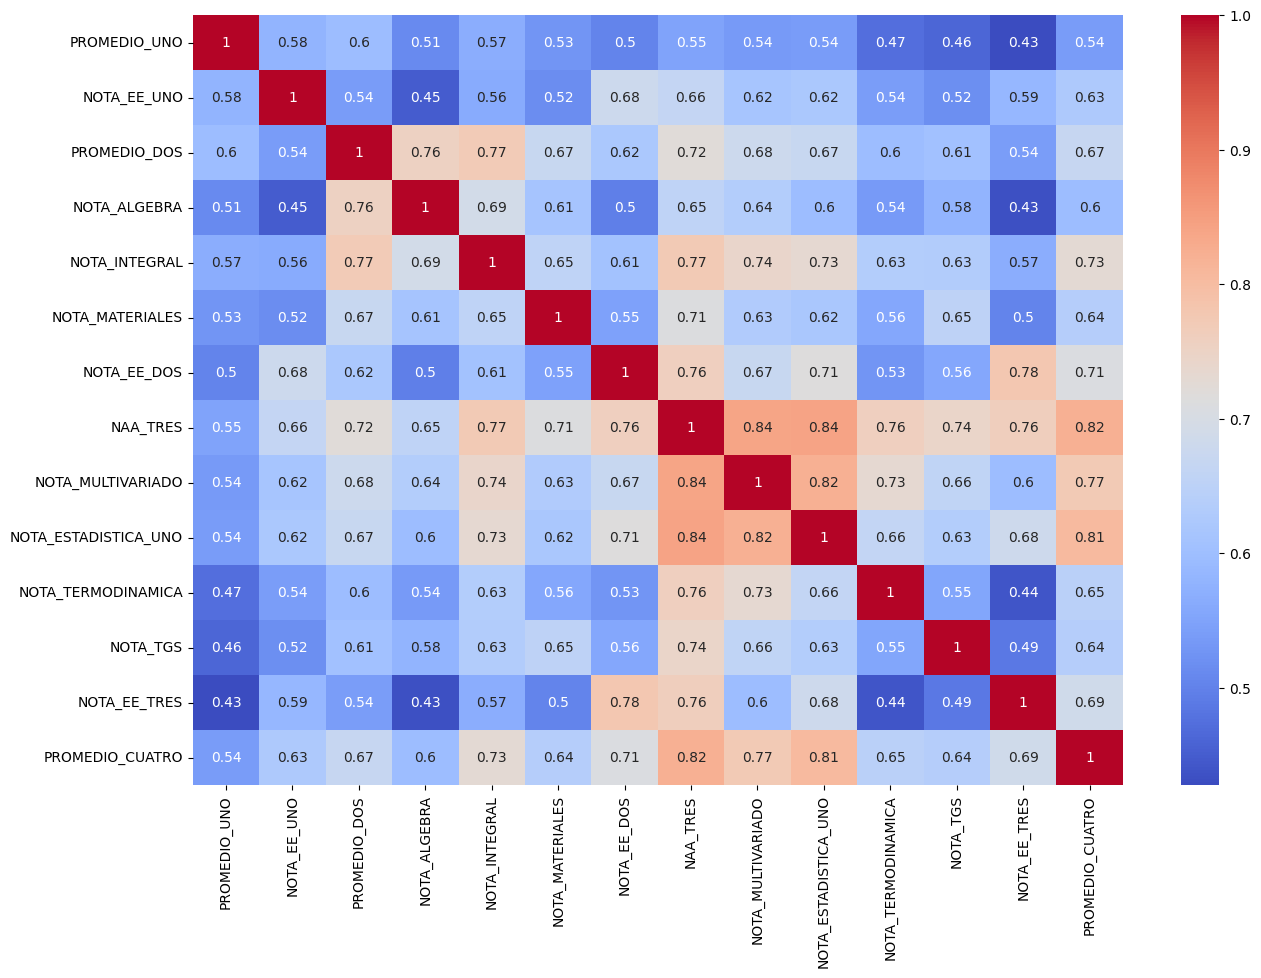

In [61]:
fig, ax = plt.subplots(figsize = (15, 10))
correlacion=df.corr(method='spearman')
sns.heatmap(correlacion,xticklabels=correlacion.columns,yticklabels=correlacion.columns,cmap='coolwarm',annot=True)

In [10]:
X_T_JOHNSON1 = X.copy(deep=True)
def transformacion_johnson(X):
    transformador_johnson = PowerTransformer(method='yeo-johnson', standardize=True).fit(X)
    datos_transformados = transformador_johnson.transform(X)
    set_printoptions(precision=3)
    print(datos_transformados[:5, :])
    datos_transformados_df = pd.DataFrame(data=datos_transformados, columns=X.columns)
    return datos_transformados_df
Xpandas_T_JOHNSON1 = transformacion_johnson(X_T_JOHNSON1)
Xpandas_T_JOHNSON1.head(2)

[[ 0.531 -0.894  0.882  0.965  0.933  1.357]
 [ 0.651 -0.072  0.932  0.851  0.104  0.571]
 [ 0.651  0.391  0.882  0.895 -1.102 -0.488]
 [ 1.218  0.735  0.903  0.955  1.609 -0.3  ]
 [ 2.506  2.974  0.969  1.072 -0.304 -2.357]]


,PG_ICFES,CON_MAT_ICFES,FISICA_ICFES,QUIMICA_ICFES,IDIOMA_ICFES,LOCALIDAD
0,0.531471,-0.894366,0.882446,0.964925,0.932902,1.357424
1,0.650876,-0.072121,0.931926,0.851496,0.103605,0.570894


In [11]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(Xpandas_T_JOHNSON1, Y, test_size=0.3, random_state=2)
print('DATOS: Son {} datos para entrenamiento y {} datos para prueba'.format(X_trn.shape[0], X_tst.shape[0]))

DATOS: Son 1411 datos para entrenamiento y 606 datos para prueba


### KNEIGHBORSREGRESSOR

In [12]:
def entrenar_modelo_knn_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = {
        'n_neighbors': [i for i in range(1, 18, 1)],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'algorithm': ['auto'],
        'p': [i for i in range(1, 6)],
        'weights': ['uniform']
    }
    modelo = KNeighborsRegressor()
    semilla = 5
    num_folds = 10
    kfold =StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica = 'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn_transformado, Y_trn)
    mejor_modelo = KNeighborsRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    mejores_hiperparametros_knn=grid_resultado.best_params_
    return mejor_modelo,grid_resultado.best_params_
modelo_knn,mejores_hiperparametros_knn  = entrenar_modelo_knn_con_transformacion(X_trn, Y_trn)
mejores_hiperparametros_knn 

{'algorithm': 'auto',
 'metric': 'manhattan',
 'n_neighbors': 17,
 'p': 1,
 'weights': 'uniform'}

In [13]:
Y_pred_prueba = modelo_knn.predict(X_tst)
r2_knn = r2_score(Y_tst, Y_pred_prueba)
r2_knn

-0.0230339271539044

### SVR

In [14]:
def entrenar_modelo_svc_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = { 'kernel':  ['rbf', 'poly', 'sigmoid','linear'], 
            'C': [i/10000 for i in range(8,12,1)],
            'max_iter':[i for i in range(1,3,1)],
            'gamma' : [i/100 for i in range(90,110,5)]}
    modelo = SVR()
    semilla=5
    num_folds=10
    kfold =StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica = 'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn_transformado, Y_trn)
    mejor_modelo = SVR(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    mejores_hiperparametros_svc=grid_resultado.best_params_
    return mejor_modelo,grid_resultado.best_params_

modelo_svc,mejores_hiperparametros_svc = entrenar_modelo_svc_con_transformacion(X_trn, Y_trn)

In [15]:
Y_pred_prueba = modelo_svc.predict(X_tst)
r2_svc = r2_score(Y_tst, Y_pred_prueba)
r2_svc

-0.7698765550800049

### DECISION TREE

In [16]:
def entrenar_modelo_tree_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = {          
            'max_depth':[i for i in range(1,7,1)], 
            'min_samples_leaf' : [i for i in range(1,7,1)], 
            'max_features' : [i for i in range(1,7,1)], 
            'splitter': ["best", "random"],
            'random_state': [i for i in range(1,7,1)]}
    modelo = DecisionTreeRegressor()
    semilla=7
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica = 'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejor_modelo = DecisionTreeRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    mejores_hiperparametros_tree=grid_resultado.best_params_
    return mejor_modelo, grid_resultado.best_params_

modelo_tree,mejores_hiperparametros_tree = entrenar_modelo_tree_con_transformacion(X_trn, Y_trn)

In [17]:
Y_pred_prueba = modelo_tree.predict(X_tst)
r2_tree = r2_score(Y_tst, Y_pred_prueba)
r2_tree

-0.006564783343039116

### NAIVE BAYES

In [18]:
def entrenar_modelo_gaussian_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    kernel1 = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-4, 1e4))
    kernel2 = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-4, 1e4)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
    parameters = {
        #'kernel': [kernel1, kernel2],
        'alpha': [1e-10, 1e-5, 1e-2, 1e-1],
        'n_restarts_optimizer': [0, 1, 2, 3],
        'normalize_y': [True, False],
        'optimizer': ['fmin_l_bfgs_b']
    }
    modelo = GaussianProcessRegressor()
    semilla=7
    num_folds=10
    kfold =StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica = 'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejor_modelo = GaussianProcessRegressor(**grid_resultado.best_params_)
    mejores_hiperparametros_gaussian=grid_resultado.best_params_
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_

modelo_gaussian,mejores_hiperparametros_gaussian = entrenar_modelo_gaussian_con_transformacion(X_trn, Y_trn)

In [19]:
Y_pred_prueba = modelo_gaussian.predict(X_tst)
r2_gaussian = r2_score(Y_tst, Y_pred_prueba)
r2_gaussian

-0.0979077605646328

### LDA

In [20]:
def entrenar_modelo_LDA_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = { 'solver':  ['svd','lsqr','eigen'],
            'n_components':[1,2,3,4,5,6,7,8,9,10],
            'shrinkage': ['auto', 0.001, 0.01, 0.1, 0.5,1,10,100,1000]
            #'tol':[i/1000 for i in range(1,100,1)]
            }
    modelo = LinearDiscriminantAnalysis()
    semilla=7
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica= 'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejor_modelo = LinearDiscriminantAnalysis(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    mejores_hiperparametros_LDA=grid_resultado.best_params_
    return mejor_modelo,grid_resultado.best_params_

modelo_LDA,mejores_hiperparametros_LDA = entrenar_modelo_LDA_con_transformacion(X_trn, Y_trn)

In [21]:
Y_pred_prueba = modelo_LDA.predict(X_tst)
r2_LDA = r2_score(Y_tst, Y_pred_prueba)
r2_LDA

-0.26259991622575796

### BAGGING

In [22]:
def entrenar_modelo_BG_con_transformacion(X_trn, Y_trn,mejores_hiperparametros_tree):
    # Aplicar la transformación Yeo-Johnson
    X_trn_transformado = X_trn
    parameters = {'n_estimators': [i for i in range(750,760,5)],
            'max_samples' : [i/100.0 for i in range(70,90,5)],
            'max_features': [i/100.0 for i in range(75,85,5)],
            'bootstrap': [True], 
            'bootstrap_features': [True]}
    base_estimator= DecisionTreeRegressor(**mejores_hiperparametros_tree)
    semilla=7
    modelo = BaggingRegressor(estimator=base_estimator)
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica =  'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejores_hiperparametros_BG=grid_resultado.best_params_
    mejor_modelo = BaggingRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_
X_trn = X_trn
Y_trn = Y_trn 
modelo_BG,mejores_hiperparametros_BG = entrenar_modelo_BG_con_transformacion(X_trn, Y_trn,mejores_hiperparametros_tree)

In [23]:
Y_pred_prueba = modelo_BG.predict(X_tst)
r2_BG = r2_score(Y_tst, Y_pred_prueba)
r2_BG

-0.012195457833436452

### RANDOM FOREST

In [24]:
def entrenar_modelo_random_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = { 
                'min_samples_split' : [1, 2 , 3,  4 , 6 , 8 , 10 , 15, 20 ],  
                'min_samples_leaf' : [ 1 , 3 , 5 , 7 , 9, 12, 15 ],
            }
    modelo = RandomForestRegressor()
    semilla=7
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica =  'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejores_hiperparametros_random=grid_resultado.best_params_
    mejor_modelo = RandomForestRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_

modelo_random,mejores_hiperparametros_random = entrenar_modelo_random_con_transformacion(X_trn, Y_trn)

In [25]:
Y_pred_prueba = modelo_random.predict(X_tst)
r2_random = r2_score(Y_tst, Y_pred_prueba)
r2_random

0.0014574460947084367

### EXTRATREES REGRESSOR

In [26]:
def entrenar_modelo_extra_con_transformacion(X_trn, Y_trn):
    # Aplicar la transformación Yeo-Johnson
    X_trn_transformado = X_trn
    parameters = {'min_samples_split' : [i for i in range(1,10,1)], 
                #'min_samples_leaf' : [i for i in range(0,10,1)],
                #'max_features':[i for i in range(0,5,1)],
                #'max_depth':[i for i in range(0,5,1)],
                #'min_samples_leaf':[i for i in range(0,10,1)],
                #'min_samples_split':[i for i in range(0,10,1)],
                'criterion':('absolute_error', 'squared_error', 'friedman_mse', 'poisson')}
    semilla=7            
    modelo = ExtraTreesRegressor(random_state=semilla, 
                                n_estimators=40,
                                bootstrap=True) 
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica ='neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejores_hiperparametros_extra=grid_resultado.best_params_
    mejor_modelo = ExtraTreesRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_

modelo_extra,mejores_hiperparametros_extra = entrenar_modelo_extra_con_transformacion(X_trn, Y_trn)

In [27]:
Y_pred_prueba = modelo_extra.predict(X_tst)
r2_extra = r2_score(Y_tst, Y_pred_prueba)
r2_extra

-0.0037724860609504862

### ADABOOST

In [28]:
def entrenar_modelo_ADA_con_transformacion(X_trn, Y_trn):
    # Aplicar la transformación Yeo-Johnson
    X_trn_transformado = X_trn
    parameters = {'learning_rate' : [i/10000.0 for i in range(5,20,5)],
                  'n_estimators':[i for i in range(1,50,1)]}
    semilla=7            
    modelo = AdaBoostRegressor(estimator = None,random_state= None) 
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica ='neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejores_hiperparametros_ADA=grid_resultado.best_params_
    mejor_modelo = AdaBoostRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_

modelo_ADA, mejores_hiperparametros_ADA= entrenar_modelo_ADA_con_transformacion(X_trn, Y_trn)

In [29]:
Y_pred_prueba = modelo_ADA.predict(X_tst)
r2_ADA = r2_score(Y_tst, Y_pred_prueba)
r2_ADA

0.016485959359538893

### GRADIENT BOOSTING MACHINE 

In [30]:
def entrenar_modelo_GD_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = { 
                'learning_rate' : [0.01, 0.05, 0.1,0.15],
                #'n_estimators': [i for i in range(100,1200,100)],
                'loss':('absolute_error', 'squared_error', 'quantile', 'huber'),
                'criterion':['friedman_mse']}
    semilla=7
    modelo = GradientBoostingRegressor(random_state=semilla,
                                    n_estimators= 100,learning_rate= 0.1,max_depth= 2,
                                    min_samples_split= 2, min_samples_leaf= 3,max_features= 2)
    semilla=7
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica ='neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejores_hiperparametros_GD=grid_resultado.best_params_
    mejor_modelo = GradientBoostingRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_

modelo_GD,mejores_hiperparametros_GD = entrenar_modelo_GD_con_transformacion(X_trn, Y_trn)

In [31]:
Y_pred_prueba = modelo_GD.predict(X_tst)
r2_GD = r2_score(Y_tst, Y_pred_prueba)
r2_GD

0.014136152556050607

### XGBOOST

In [32]:
def entrenar_modelo_XB_con_transformacion(X_trn, Y_trn):
    # Aplicar la transformación Yeo-Johnson
    X_trn_transformado = X_trn
    parameters = {'reg_alpha': [0,0.1,0.2,0.3,0.4,0.5],
                'reg_lambda':  [i/1000.0 for i in range(100,150,5)],
                #'n_estimators':  [i for i in range(1,10,2)],
                'colsample_bytree': [0.1,0.3, 0.5,0.6,0.7,0.8, 0.9, 1,1.1],
                #'objective' : ('binary:logistic', 'Multi: softprob'),
                #'loss': ['log_loss'],
                'max_features':('sqrt','log2')
                }
    semilla=7
    modelo = XGBRegressor(random_state=semilla,subsample =1,max_depth =2)
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica ='neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejores_hiperparametros_XB=grid_resultado.best_params_
    mejor_modelo = XGBRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_

modelo_XB,mejores_hiperparametros_XB = entrenar_modelo_XB_con_transformacion(X_trn, Y_trn)

In [33]:
Y_pred_prueba = modelo_XB.predict(X_tst)
r2_XB = r2_score(Y_tst, Y_pred_prueba)
r2_XB

-0.2249264225131029

### CATBOOST

In [34]:
def entrenar_modelo_CB_con_transformacion(X_trn, Y_trn):
    # Aplicar la transformación Yeo-Johnson
    X_trn_transformado = X_trn
    parameters = {} 
    semilla=7
    modelo = CatBoostRegressor(random_state=semilla, verbose =0)
    semilla=7
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica ='neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejores_hiperparametros_CB=grid_resultado.best_params_
    mejor_modelo = CatBoostRegressor(verbose=0,**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_

modelo_CB,mejores_hiperparametros_CB = entrenar_modelo_CB_con_transformacion(X_trn, Y_trn)

In [35]:
Y_pred_prueba = modelo_CB.predict(X_tst)
r2_CB = r2_score(Y_tst, Y_pred_prueba)
r2_CB

-0.03910104595770769

### LIGHT GBM

In [36]:
def entrenar_modelo_LIGHT_con_transformacion(X_trn, Y_trn):
    # Aplicar la transformación Yeo-Johnson
    X_trn_transformado = X_trn
    parameters = {
    'min_child_samples' : [i for i in range(1, 1000, 100)],'colsample_bytree': [0.6, 0.8, 1.0,1.5],
    'boosting_type': ['gbdt', 'dart', 'goss'],'objective': ['binary', 'multiclass'],'random_state': [42]}
    semilla=7
    modelo = LGBMRegressor(random_state=semilla,                           
                            num_leaves =  10,max_depth = 1, n_estimators = 100,    
                            learning_rate = 0.1 ,class_weight=  None, subsample = 1,
                            colsample_bytree= 1, reg_alpha=  0, reg_lambda = 0,
                            min_split_gain = 0, boosting_type = 'gbdt')
    semilla=7
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica ='neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejores_hiperparametros_LIGHT=grid_resultado.best_params_
    mejor_modelo = LGBMRegressor(verbose=-1,**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_

modelo_LIGHT,mejores_hiperparametros_LIGHT = entrenar_modelo_LIGHT_con_transformacion(X_trn, Y_trn)

[LightGBM] [Info] Number of positive: 1395, number of negative: 16
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.988661 -> initscore=4.468061
[LightGBM] [Info] Start training from score 4.468061


In [37]:
Y_pred_prueba = modelo_LIGHT.predict(X_tst)
r2_LIGHT = r2_score(Y_tst, Y_pred_prueba)
r2_LIGHT

-10.506175596577277

In [38]:
mejores_hiperparametros_knn = modelo_knn.get_params()
mejores_hiperparametros_knn

mejores_hiperparametros_GD = modelo_GD.get_params()
mejores_hiperparametros_GD

mejores_hiperparametros_tree = modelo_tree.get_params()
mejores_hiperparametros_tree

mejores_hiperparametros_ADA = modelo_ADA.get_params()
mejores_hiperparametros_ADA

mejores_hiperparametros_extra = modelo_extra.get_params()
mejores_hiperparametros_extra

mejores_hiperparametros_random = modelo_random.get_params()
mejores_hiperparametros_random

mejores_hiperparametros_BG = modelo_BG.get_params()
mejores_hiperparametros_BG

mejores_hiperparametros_XB = modelo_XB.get_params()
mejores_hiperparametros_XB

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.1,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 0.2,
 'reg_lambda': 0.135,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'max_features': 'sqrt'}

### VOTING

In [39]:
def entrenar_modelo_voting_con_transformacion(X_trn, Y_trn,
                                                   mejores_hiperparametros_GD,
                                                   mejores_hiperparametros_tree,
                                                   mejores_hiperparametros_ADA,
                                                   mejores_hiperparametros_extra,
                                                   mejores_hiperparametros_random,
                                                   mejores_hiperparametros_BG,
                                                   mejores_hiperparametros_XB):
    X_trn_transformado = X_trn
    semilla= 7 
    kfold = StratifiedKFold(n_splits=10, random_state=semilla, shuffle=True)
    modelo1 = GradientBoostingRegressor(**mejores_hiperparametros_GD)
    base_estimator=DecisionTreeRegressor(**mejores_hiperparametros_tree)
    modelo2 = AdaBoostRegressor(**mejores_hiperparametros_ADA)
    modelo3 = ExtraTreesRegressor(**mejores_hiperparametros_extra)
    modelo4 = RandomForestRegressor(**mejores_hiperparametros_random)
    model = DecisionTreeRegressor(**mejores_hiperparametros_tree)
    modelo5 = BaggingRegressor(**mejores_hiperparametros_BG)
    modelo6 = DecisionTreeRegressor(**mejores_hiperparametros_tree)
    modelo7 = XGBRegressor(**mejores_hiperparametros_XB)
    metrica ='neg_mean_squared_error'
    mejor_modelo = VotingRegressor(
    estimators=[('Gradient', modelo1), ('Adaboost', modelo2), 
                                    ('Extratrees', modelo3),('Random Forest',modelo4),
                                    ('Bagging',modelo5),('Decision tree',modelo6),
                                    ('XGB',modelo7)]) 
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    resultados = cross_val_score(mejor_modelo, X_trn_transformado, Y_trn, 
                                    cv=kfold,scoring = metrica)
    mejores_hiperparametros_voting=mejor_modelo.get_params

    return mejor_modelo, mejores_hiperparametros_voting
modelo_voting, mejores_hiperparametros_voting= entrenar_modelo_voting_con_transformacion(X_trn, Y_trn,
                                                   mejores_hiperparametros_GD,
                                                   mejores_hiperparametros_tree,
                                                   mejores_hiperparametros_ADA,
                                                   mejores_hiperparametros_extra,
                                                   mejores_hiperparametros_random,
                                                   mejores_hiperparametros_BG,
                                                   mejores_hiperparametros_XB)

In [40]:
Y_pred_prueba = modelo_voting.predict(X_tst)
r2_voting = r2_score(Y_tst, Y_pred_prueba)
r2_voting

0.012374385157974288

### STACKING LINEAL

In [41]:
def entrenar_modelo_stacking_lineal_con_transformacion(X_trn, Y_trn,
                                                   mejores_hiperparametros_tree,
                                                   mejores_hiperparametros_ADA,
                                                   mejores_hiperparametros_extra,
                                                   mejores_hiperparametros_random,
                                                   mejores_hiperparametros_BG):
    X_trn_transformado = X_trn
    semilla= 7 
    kfold = StratifiedKFold(n_splits=10, random_state=semilla, shuffle=True)
    base_estimator=DecisionTreeRegressor(**mejores_hiperparametros_tree)
    modelo2 = AdaBoostRegressor(**mejores_hiperparametros_ADA)
    modelo3 = ExtraTreesRegressor(**mejores_hiperparametros_extra)
    modelo4 = RandomForestRegressor (**mejores_hiperparametros_random)
    model = DecisionTreeRegressor(**mejores_hiperparametros_tree)
    modelo5 = BaggingRegressor(**mejores_hiperparametros_BG)
    modelo6 = DecisionTreeRegressor(**mejores_hiperparametros_tree)
    estimador_final = LinearRegression()
    metrica ='neg_mean_squared_error'
    mejor_modelo = StackingRegressor(
    estimators=[ ('Adaboost', modelo2), ('Extratrees', modelo3),
                ('Random Forest',modelo4),
                #('Bagging',modelo5)
                ('Decision tree',modelo6)
                ], 
                                    final_estimator=estimador_final) 
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    mejores_hiperparametros_stacking_lineal=mejor_modelo.get_params
    resultados = cross_val_score(mejor_modelo, X_trn_transformado, Y_trn, cv=kfold,scoring = metrica)
    return mejor_modelo,mejores_hiperparametros_stacking_lineal


modelo_stacking_lineal,mejores_hiperparametros_stacking_lineal = entrenar_modelo_stacking_lineal_con_transformacion(X_trn, Y_trn,
                                                   mejores_hiperparametros_tree,
                                                   mejores_hiperparametros_ADA,
                                                   mejores_hiperparametros_extra,
                                                   mejores_hiperparametros_random,
                                                   mejores_hiperparametros_BG)

In [42]:
Y_pred_prueba = modelo_stacking_lineal.predict(X_tst)
r2_stacking_lineal = r2_score(Y_tst, Y_pred_prueba)
r2_stacking_lineal

0.014149881236720563

### STACKING NO LINEAL

In [43]:
def entrenar_modelo_stacking_nolineal_con_transformacion(X_trn, Y_trn,
                                                   mejores_hiperparametros_tree,
                                                   mejores_hiperparametros_ADA,
                                                   mejores_hiperparametros_extra,
                                                   mejores_hiperparametros_random,
                                                   mejores_hiperparametros_BG):
    X_trn_transformado = X_trn
    semilla= 7 
    kfold = StratifiedKFold(n_splits=10, random_state=semilla, shuffle=True)
    base_estimator=DecisionTreeRegressor(**mejores_hiperparametros_tree)
    modelo2 = AdaBoostRegressor(**mejores_hiperparametros_ADA)
    modelo3 = ExtraTreesRegressor(**mejores_hiperparametros_extra)
    modelo4 = RandomForestRegressor (**mejores_hiperparametros_random)
    model = DecisionTreeRegressor(**mejores_hiperparametros_tree)
    modelo5 = BaggingRegressor(**mejores_hiperparametros_BG)
    modelo6 = DecisionTreeRegressor(**mejores_hiperparametros_tree)
    estimador_final = ExtraTreesRegressor()
    metrica ='neg_mean_squared_error'
    mejor_modelo = StackingRegressor(
    estimators=[ ('Adaboost', modelo2), ('Extratrees', modelo3),
                ('Random Forest',modelo4),
                #('Bagging',modelo5)
                ('Decision tree',modelo6)
                ], 
                                    final_estimator=estimador_final) 
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    mejores_hiperparametros_stacking_nolineal=mejor_modelo.get_params
    resultados = cross_val_score(mejor_modelo, X_trn_transformado, Y_trn, cv=kfold,scoring = metrica)
    return mejor_modelo,mejores_hiperparametros_stacking_nolineal


modelo_stacking_nolineal,mejores_hiperparametros_stacking_nolineal = entrenar_modelo_stacking_nolineal_con_transformacion(X_trn, Y_trn,
                                                   mejores_hiperparametros_tree,
                                                   mejores_hiperparametros_ADA,
                                                   mejores_hiperparametros_extra,
                                                   mejores_hiperparametros_random,
                                                   mejores_hiperparametros_BG)

In [44]:
Y_pred_prueba = modelo_stacking_nolineal.predict(X_tst)
r2_stacking_nolineal = r2_score(Y_tst, Y_pred_prueba)
r2_stacking_nolineal

-0.05493669588240491

### SUPER APRENDIZ

In [45]:
Y_trn = Y_trn.astype(int)
def entrenar_modelo_super_aprendiz(X_trn, Y_trn, mejores_hiperparametros_GD,
                            mejores_hiperparametros_tree,mejores_hiperparametros_extra,
                            mejores_hiperparametros_random):
    X_trn_transformado = X_trn
    semilla = 7 
    kfold = StratifiedKFold(n_splits=10, random_state=semilla, shuffle=True)
    modelo1 = ExtraTreesRegressor(**mejores_hiperparametros_extra)
    modelo2 = RandomForestRegressor(**mejores_hiperparametros_random)
    model = DecisionTreeRegressor(**mejores_hiperparametros_tree)
    #modelo3 = BaggingRegressor(**mejores_hiperparametros_BG)
    modelo4 = DecisionTreeRegressor(**mejores_hiperparametros_tree)
    modelo5 = GradientBoostingRegressor(**mejores_hiperparametros_GD) 
    estimadores = [('Extratrees', modelo1), 
                   ('Random Forest', modelo2), 
                #('Bagging', modelo3), 
                ('Decision tree', modelo4),
                ('Gradient',modelo5)]
    super_learner = SuperLearner(folds=10, random_state=semilla, verbose=2)
    super_learner.add(estimadores)
    estimador_final = ExtraTreesRegressor(n_estimators=100, max_features=None,
                                        bootstrap=False, max_depth=11, min_samples_split=4, 
                                        min_samples_leaf=1)
    super_learner.add_meta(estimador_final)
    super_learner.fit(X_trn_transformado, Y_trn)
    mejores_hiperparametros_super_learner=super_learner.get_params
    resultados = cross_val_score(super_learner, X_trn_transformado, Y_trn, cv=kfold, scoring='neg_mean_squared_error')
    print("Rendimiento del modelo:") 
    return super_learner,mejores_hiperparametros_super_learner,estimadores
modelo_superaprendiz,mejores_hiperparametros_super_learner,estimadores = entrenar_modelo_super_aprendiz(X_trn, Y_trn, mejores_hiperparametros_GD,
                            mejores_hiperparametros_tree,mejores_hiperparametros_extra,
                            mejores_hiperparametros_random)


Fitting 2 layers
Processing layer-1             done | 00:00:05
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:05

Fitting 2 layers
Processing layer-1             done | 00:00:04
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:04

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00

Fitting 2 layers
Processing layer-1             done | 00:00:04
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:04

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00

Fitting 2 layers
Processing layer-1             done | 00:00:04
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:04

Predicting 2 layers
Processing layer-1 

In [46]:
Y_pred_prueba = modelo_superaprendiz.predict(X_tst)
r2_superaprendiz = r2_score(Y_tst, Y_pred_prueba)
r2_superaprendiz


Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00


-0.006491644764692106

### SUPER APRENDIZ DOS CAPAS

In [47]:
def entrenar_modelo_super_aprendiz_dos_capas(X_trn, Y_trn, mejores_hiperparametros_tree,
                                            mejores_hiperparametros_extra,mejores_hiperparametros_random):
    X_trn_transformado = X_trn
    semilla = 7 
    kfold = StratifiedKFold(n_splits=10, random_state=semilla, shuffle=True)
    modelo1 = ExtraTreesRegressor(**mejores_hiperparametros_extra)
    modelo2 = RandomForestRegressor(**mejores_hiperparametros_random)
    model = DecisionTreeRegressor(**mejores_hiperparametros_tree)
    #modelo3 = BaggingRegressor(**mejores_hiperparametros_BG)
    modelo4 = DecisionTreeRegressor(**mejores_hiperparametros_tree)
    estimadores = [('Extratrees', modelo1), 
                   ('Random Forest', modelo2), 
                #('Bagging', modelo3), 
                ('Decision tree', modelo4)]
    superaprendiz_dos_capas = SuperLearner(folds=10, random_state=semilla, verbose=2)
    superaprendiz_dos_capas.add(estimadores)
    superaprendiz_dos_capas.add(estimadores)
    estimador_final = ExtraTreesRegressor(n_estimators=100, max_features=None,
                                        bootstrap=False, max_depth=11, min_samples_split=4, 
                                        min_samples_leaf=1)
    superaprendiz_dos_capas.add_meta(estimador_final)
    
    superaprendiz_dos_capas.fit(X_trn_transformado, Y_trn)
    mejores_hiperparametros_superaprendiz_dos_capas=superaprendiz_dos_capas.get_params
    resultados = cross_val_score(superaprendiz_dos_capas, X_trn_transformado, Y_trn, cv=kfold, scoring='neg_mean_squared_error')
    return superaprendiz_dos_capas,mejores_hiperparametros_superaprendiz_dos_capas,estimadores
modelo_superaprendiz_dos_capas,mejores_hiperparametros_superaprendiz_dos_capas,estimadores = entrenar_modelo_super_aprendiz_dos_capas(X_trn, Y_trn, mejores_hiperparametros_tree,
                                            mejores_hiperparametros_extra,mejores_hiperparametros_random)


Fitting 3 layers
Processing layer-1             done | 00:00:05
Processing layer-2             done | 00:00:03
Processing layer-3             done | 00:00:00
Fit complete                        | 00:00:09

Fitting 3 layers
Processing layer-1             done | 00:00:04
Processing layer-2             done | 00:00:03
Processing layer-3             done | 00:00:00
Fit complete                        | 00:00:08

Predicting 3 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Processing layer-3             done | 00:00:00
Predict complete                    | 00:00:00

Fitting 3 layers
Processing layer-1             done | 00:00:05
Processing layer-2             done | 00:00:03
Processing layer-3             done | 00:00:00
Fit complete                        | 00:00:08

Predicting 3 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Processing layer-3             done | 00:00:00
Predict com

In [48]:
Y_pred_prueba = modelo_superaprendiz_dos_capas.predict(X_tst)
r2_superaprendiz_dos_capas = r2_score(Y_tst, Y_pred_prueba)
r2_superaprendiz_dos_capas


Predicting 3 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Processing layer-3             done | 00:00:00
Predict complete                    | 00:00:00


-0.03395125481908767

### COMPARACIÓN DE MODELOS

In [49]:
exactitudes = {
    'KNEIGHBORSCLASSIFIER': r2_knn,
    'SVC': r2_svc,
    'DECISION TREE': r2_tree,
    'NAIVE BAYES':r2_gaussian,
    'LDA':r2_LDA,
    'BAGGING':r2_BG,
    'RANDOM FOREST':r2_random,
    'EXTRATREES':r2_extra,
    'ADABOOST':r2_ADA,
    'GRADIENTBOOST': r2_GD,
    'XGBOOST':r2_XB,
    'CATBOOST':r2_CB,
    'LIGHT':r2_LIGHT,
    'VOTING':r2_voting,
    'STACKING LINEAL':r2_stacking_lineal,
    'STACKING NO LINEAL':r2_stacking_nolineal,
    'SUPER APRENDIZ':r2_superaprendiz,
    'SUPER APRENDIZ DOS CAPAS':r2_superaprendiz_dos_capas
}
mejor_modelo = max(exactitudes, key=exactitudes.get)
mejor_r2 = exactitudes[mejor_modelo]

print("Mejor modelo:", mejor_modelo)
print("R^2 en prueba:", mejor_r2)

Mejor modelo: ADABOOST
R^2 en prueba: 0.016485959359538893
